In [1]:
# In[]
import datetime as dt
import heapq
import math
import os
import random
import warnings
from dataclasses import dataclass, field
from datetime import timedelta
from typing import Any

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.distributions
from dateutil import tz
import bootstrap as bs
import itertools
import importlib
import matplotlib.dates as mdates
import matplotlib

warnings.filterwarnings("ignore")


# Globals
DATA_PATH = '/Users/sunjh1999/Downloads/renewable_econ'
RENEWABLE_PATH = os.path.join(
    DATA_PATH, 'renewable/')

In [2]:
importlib.reload(bs)
bs.set_my_custom_size()

In [3]:
CAPACITY=400

In [4]:
df: DataFrame = pd.read_csv(os.path.join(RENEWABLE_PATH, 'all_2015.csv'), parse_dates=['TIME'])

In [5]:
st = pd.Timestamp("2015-05-01 00:00:00")
ed = st + pd.Timedelta(days=30)
filtered_df = df[(df['TIME'] >= st) & (df['TIME'] <= ed)]

In [6]:
df['TIME'].max()

Timestamp('2015-12-31 23:00:00')

In [7]:
filtered_df['TIME_DELTA'] = filtered_df['TIME'] - filtered_df['TIME'].min()

1.6364095915192134
0.23803525692218885
0.16317520973174965
1.301501771622136
0.8378851612063304
0.5477758959307496
1.2484812698860759
0.4395569130378455
0.23074189695298447


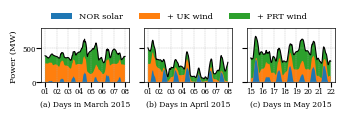

In [8]:
import bootstrap as bs
plt.rcParams.update({'figure.max_open_warning': 0})
# matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'font.family': 'serif'})
matplotlib.rcParams['xtick.major.pad'] = '8'
matplotlib.rcParams['ytick.major.pad'] = '8'
matplotlib.rcParams['hatch.linewidth'] = 0.5
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(1, 3, figsize=bs.get_fig_size(1, 0.5), sharey=True)
tstart = ["2015-03-01 00:00:00", "2015-04-01 00:00:00", "2015-05-15 00:00:00"]
mstart = ["March", "April", "May"]
sublabels = ["(a)", "(b)", "(c)"]
for i,ax in enumerate(axes):
    st = pd.Timestamp(tstart[i])
    ed = st + pd.Timedelta(days=7)
    filtered_df = df[(df['TIME'] >= st) & (df['TIME'] <= ed)]
    filtered_df['TIME_DELTA'] = filtered_df['TIME'] - filtered_df['TIME'].min()


    MIN_PWR = 420

    current_sum = filtered_df['NO_solar'].copy()
    print(np.std(current_sum) / np.average(current_sum))
    ax.fill_between(filtered_df['TIME'], 0, current_sum * CAPACITY, label='NOR solar', zorder=1)
    current_sum += filtered_df['UK_wind']
    print(np.std(current_sum) / np.average(current_sum))
    ax.fill_between(filtered_df['TIME'], 0, current_sum * CAPACITY, label='+ UK wind', zorder=0)
    current_sum += filtered_df['PT_wind']
    print(np.std(current_sum) / np.average(current_sum))
    ax.fill_between(filtered_df['TIME'], 0, current_sum * CAPACITY, label='+ PRT wind', zorder=-1)
    # ax.fill_between(filtered_df['TIME'], current_sum * CAPACITY, MIN_PWR, label='+ Purchased', zorder=-2, facecolor="lightgrey", hatch="X", edgecolor="grey", linewidth=0.0)
    # ax.fill_between(filtered_df['TIME'], current_sum * CAPACITY, MIN_PWR, label='+ Purchased', zorder=-2, transparency=0.5)
    ax.plot(filtered_df['TIME'], (current_sum * CAPACITY), color='black', ls='-')
    # ax.axvline(x=st + pd.Timedelta(days=7), color="black", ls='--')

    ax.grid()
    ax.set_xlabel(f'{sublabels[i]} Days in {mstart[i]} 2015', **{'fontname': 'serif', "fontsize" : 5.5})
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))    # every day
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d')) 
    # if i == 1:
        # legend = ax.legend(ncol=3, bbox_to_anchor=(0.5, 1), loc="lower center", frameon=False)
    ax.set_ylim(0, 800)
    ax.tick_params(axis='both', which='major', labelsize=5, pad=0.3)

handles,labels=[],[]
for ax in axes.flatten()[:1]:
    h, l = ax.get_legend_handles_labels()
    handles+=h
    labels+=l
lgd = fig.legend(handles, labels, loc="upper center", frameon=False, ncol=len(labels), bbox_to_anchor=(0.5, 1.1), bbox_transform=fig.transFigure)

# # fig.text(0.22, 0.8, 'Week One', va='center', weight='bold')
#     ax.grid()
#     ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))    # every day
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%d')) 
#     # fig.autofmt_xdate()
    
fig.text(-0.01, 0.6, 'Power (MW)', va='center', rotation='vertical')
plt.tight_layout()
# plt.show()
fig.savefig('figs/stacked_comb_three_periods.pdf', bbox_inches='tight')

filtered_df['NO_solar']

In [9]:
filtered_df['NO_solar'].min(), filtered_df['UK_wind'].min(), filtered_df['PT_wind'].min()

(0.0, 0.0256264705882352, 0.2869414285714285)

In [10]:
def improvement_function(input_arr):
    arr = list(input_arr.copy())
    x = np.array(sorted(arr))
    n = len(x)
    
    prefix_sum = np.zeros(n)
    energy = np.zeros(n) # Extra energy in MHhr
    min_pwr = np.zeros(n)
    
    prefix_sum[0] = x[0]
    min_pwr[0] = x[0]
    energy[0] = 0
    
    for i in range(1, n):
        prefix_sum[i] = prefix_sum[i-1] + x[i]
        energy[i] = i * x[i] - prefix_sum[i-1]
        min_pwr[i] = x[i]
    
    return pd.DataFrame({"ExtraEnergy": energy, "MinPower": min_pwr})

In [11]:
def improvement_function2(input_arr):
    arr = list(input_arr.copy())
    x = np.array(sorted(arr))
    n = len(x)
    
    energy = list() # Extra energy in MHhr
    min_pwr = np.linspace(x.min(), x.max(), 1000)
    
    for mp in min_pwr:
        this_energy = 0
        for xi in x:
            if(xi < mp):
                this_energy += mp - xi
        energy.append(this_energy)
    return pd.DataFrame({"ExtraEnergy": energy, "MinPower": min_pwr})

In [12]:
tstart = "2015-01-01 00:00:00"
i = 0
sites = "AT_solar,BE_solar,BG_solar,CH_solar,CZ_solar,DE_solar,EL_solar,ES_solar,FI_solar,FR_solar,HU_solar,IE_solar,IT_solar,NL_solar,NO_solar,PL_solar,PT_solar,RO_solar,SE_solar,SK_solar,UK_solar,AT_wind,BE_wind,BG_wind,CH_wind,CZ_wind,DE_wind,DK_wind,ES_wind,FI_wind,FR_wind,GR_wind,HR_wind,HU_wind,IE_wind,IT_wind,NL_wind,NO_wind,PL_wind,PT_wind,RO_wind,SE_wind,SI_wind,SK_wind,UK_wind".split(",")

st = pd.Timestamp(tstart)
all_combs = list(itertools.combinations(sites, 3))
durations = []

for comb_i, subset in enumerate(all_combs):
    wind_sites = [s for s in subset if "wind" in s]
    if len(wind_sites) <= 1:
        continue
    # durations = []
    for i in range(365):
        iter_st = st + pd.Timedelta(days=i)
        iter_ed = iter_st + pd.Timedelta(days=3)
        filtered_df = df[(df['TIME'] >= iter_st) & (df['TIME'] <= iter_ed)]
        current_sum = filtered_df[subset[0]].copy()
        current_sum += filtered_df[subset[1]]
        current_sum += filtered_df[subset[2]]
        cov = np.std(current_sum) / np.average(current_sum)
        if cov <= 0.2:
            duration = 3
            for d in range(3, 15):
                ter_st = st + pd.Timedelta(days=i)
                iter_ed = iter_st + pd.Timedelta(days=d)
                filtered_df = df[(df['TIME'] >= iter_st) & (df['TIME'] <= iter_ed)]
                current_sum = filtered_df['NO_solar'].copy()
                current_sum += filtered_df['UK_wind']
                current_sum += filtered_df['PT_wind']
                new_cov = np.std(current_sum) / np.average(current_sum)
                # print(d, cov, new_cov)
                if new_cov > 0.2:
                    duration = d
                    break
            # print(i, duration)
            durations.append(duration)
    print(comb_i, len(all_combs))
    if len(durations) > 0:
        print(len(durations), np.average(durations), max(durations))


670 14190
14 6.214285714285714 11
671 14190
23 5.782608695652174 11
672 14190
33 5.757575757575758 11
673 14190
43 5.767441860465116 11
674 14190
59 5.830508474576271 11
675 14190
69 5.72463768115942 11
676 14190
79 5.6835443037974684 11
677 14190
101 5.811881188118812 13
678 14190
121 5.776859504132231 13
679 14190
125 5.704 13
680 14190
129 5.705426356589148 13
681 14190
135 5.711111111111111 13
682 14190
145 5.7172413793103445 13
683 14190
150 5.74 13
684 14190
164 5.7317073170731705 13
685 14190
184 5.7228260869565215 13
686 14190
197 5.715736040609137 13
687 14190
220 5.631818181818182 13
688 14190
227 5.6255506607929515 13
689 14190
242 5.6115702479338845 13
690 14190
248 5.612903225806452 13
691 14190
249 5.634538152610442 13
692 14190
269 5.62453531598513 13
693 14190
271 5.630996309963099 13
694 14190
278 5.66546762589928 13
695 14190
287 5.682926829268292 13
696 14190
298 5.74496644295302 13
697 14190
305 5.7901639344262295 13
698 14190
329 5.7051671732522795 13
699 14190
341

KeyboardInterrupt: 

In [ ]:
improvement_df = improvement_function(filtered_df['NO_solar'])
improvement_df = improvement_function2(filtered_df['NO_solar'])
improvement_df

In [ ]:
from collections import namedtuple
Line = namedtuple("Line", ['label', 'data'])
lines = [
    Line('NO solar', filtered_df['NO_solar']),
    Line('UK wind', filtered_df['UK_wind']),
    Line('PT wind', filtered_df['PT_wind']),
    Line('NO solar + UK wind',  + filtered_df['NO_solar'] + filtered_df['UK_wind']),
    Line('NO solar + UK wind + PT wind', filtered_df['NO_solar'] + filtered_df['UK_wind'] + filtered_df['PT_wind']),
]

In [ ]:
fig, ax = plt.subplots(figsize=bs.get_fig_size())
for line in lines:
    improvement_df = improvement_function2(line.data)
    print(line.label)
    display((improvement_df * CAPACITY).iloc[700:750])
    total_energy = line.data.sum()
    print(total_energy)
    original_min = line.data.min()
    additional_energy = (improvement_df['MinPower'] - original_min) * len(filtered_df) - improvement_df['ExtraEnergy']
    ax.plot(improvement_df['ExtraEnergy'] * CAPACITY, CAPACITY*(improvement_df['MinPower']), label=line.label)
ax.grid()
ax.set_xlabel('Energy Purchased (MWhr)')
ax.set_ylabel('Stable Power (MW)')
ax.legend(ncol = 2, loc='lower center', bbox_to_anchor=(0.5, 1))
ax.grid(True)
# ax.set_xlim(0, 0.5)
fig.savefig('../figs/stable_power(A+B).pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=bs.get_fig_size())
for line in lines:
    improvement_df = improvement_function2(line.data)
    total_energy = line.data.sum()
    print(total_energy)
    original_min = line.data.min()
    additional_energy = (improvement_df['MinPower'] - original_min) * len(filtered_df) - improvement_df['ExtraEnergy']
    ax.plot(improvement_df['ExtraEnergy'] * CAPACITY, CAPACITY*(improvement_df['MinPower'] - original_min), label=line.label)
ax.grid()
ax.set_xlabel('Energy Purchased (MWhr)')
ax.set_ylabel('Additional Stable Power (MW)')
ax.legend(ncol = 2, loc='lower center', bbox_to_anchor=(0.5, 1))
ax.grid(True)
# ax.set_xlim(0, 0.5)
fig.savefig('../figs/additional_power(A+B).pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=bs.get_fig_size())
for line in lines:
    improvement_df = improvement_function2(line.data)
    total_energy = line.data.sum()
    print(total_energy)
    original_min = line.data.min()
    additional_energy = (improvement_df['MinPower'] - original_min) * len(filtered_df) - improvement_df['ExtraEnergy']
    ax.plot(improvement_df['ExtraEnergy'] * CAPACITY, additional_energy * CAPACITY, label=line.label)
ax.grid()
ax.set_xlabel('Energy Purchased (MWhr)')
ax.set_ylabel('Additional Stable Energy (MWhr)')
ax.legend(ncol = 2, loc='lower center', bbox_to_anchor=(0.5, 1))
ax.grid(True)
# ax.set_xlim(0, 0.5)
fig.savefig('../figs/additional_energy(B).pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=bs.get_fig_size())
for line in lines:
    improvement_df = improvement_function2(line.data)
    total_energy = line.data.sum()
    print(total_energy)
    original_min = line.data.min()
    additional_energy = (improvement_df['MinPower'] - original_min) * len(filtered_df) - improvement_df['ExtraEnergy']
    ax.plot(improvement_df['ExtraEnergy']/total_energy, additional_energy/total_energy, label=line.label)
ax.grid()
ax.set_xlabel('Relative Energy Purchased')
ax.set_ylabel('Relative Additional Stable Energy')
ax.legend(ncol = 2, loc='lower center', bbox_to_anchor=(0.5, 1))
ax.grid(True)
ax.set_xlim(0, 0.5)
fig.savefig('../figs/additional_energy_zoom.pdf', bbox_inches='tight')
plt.show()

In [ ]:
sources = ['NO_solar', 'UK_wind', 'PT_wind']

In [ ]:
get_tag = lambda x: x[:2]
xx = []
yy_harvest = []
yy_stable = []
for comb_length in range(1, len(sources)+1):
    for subset in itertools.combinations(sources, comb_length):
        this_data = filtered_df[subset[0]].copy()
        for i in range(1, len(subset)):
            this_data += filtered_df[subset[i]]
        xx.append(" + ".join([get_tag(x) for x in subset]))
        total_energy = this_data.sum()
        stable_energy = this_data.min() * len(this_data)
        harvest_energy = total_energy - stable_energy
        yy_stable.append(CAPACITY * stable_energy)
        yy_harvest.append(CAPACITY * harvest_energy)

In [ ]:
comb_df = pd.DataFrame({'Site Combination': xx, 'Stable Energy': yy_stable, 'Variable Energy': yy_harvest})

In [ ]:
print("Site StableEnergy TotalEnergy")
ax = comb_df.plot.bar(x='Site Combination', figsize=bs.get_fig_size(1, 0.6), rot=30, stacked=True, width=0.7)
ax.set_ylabel('Energy (MWhr)')
ax.grid(axis='y')

bars = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]
    
for i, row in comb_df.iterrows():
    # print(row)
    total_energy = row['Stable Energy'] + row['Variable Energy']
    percentage_variable = row['Variable Energy'] * 100 / total_energy
    print(row['Site Combination'], row['Stable Energy'], total_energy)
    
    rect = bars[i + len(comb_df)]
    height = total_energy
    ax.text(rect.get_x() + rect.get_width() / 2.0, height - rect.get_height()/2 - 1000, f'{percentage_variable:.0f}%', ha='center', va='bottom') #, rotation='vertical')

ax.set_ylim(0, 25000+5000)
plt.savefig('../figs/comb_bar_stacked.svg', bbox_inches='tight')